# Análisis de la Asociación entre Tiempo de Exposición a Pantallas y SVI en Médicos Radiólogos

Este notebook analiza la relación entre el tiempo de exposición a pantallas y el Síndrome Visual Informático (SVI) en médicos radiólogos, utilizando un enfoque de modelado estadístico inferencial.

## Objetivos
1. Analizar asociaciones bivariadas entre predictores y SVI
2. Desarrollar modelos de regresión logística
3. Identificar factores de riesgo significativos
4. Proporcionar recomendaciones basadas en evidencia

In [22]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuración de visualización
plt.style.use('default')  # Usar estilo por defecto en lugar de seaborn
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Carga y Preparación de Datos

Cargaremos el dataset simulado y realizaremos la preparación inicial de los datos.

In [23]:
# Cargar el dataset
df = pd.read_csv('d:/encuesta_fatiga_visual/data/2_processed/df_models_synthetic.csv')

# Verificar las dimensiones y primeras filas
print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (40, 64)


,edad,experiencia_radiologia,tiempo_de_exposicion,duracion_de_jornada,sexo,estado_civil,ingresos_mensuales,condiciones_oculares,lentes,iluminacion,frecuencia_de_pausas,uso_de_dispositivos,distancia_hacia_el_monitor,ardor_frecuencia,ardor_intensidad,ardor_severidad,picor_frecuencia,picor_intensidad,picor_severidad,sensacion_cuerpo_extraño_frecuencia,sensacion_cuerpo_extraño_intensidad,sensacion_cuerpo_extraño_severidad,lagrimeo_frecuencia,lagrimeo_intensidad,lagrimeo_severidad,parpadeo_excesivo_frecuencia,parpadeo_excesivo_intensidad,parpadeo_excesivo_severidad,enrojecimiento_ocular_frecuencia,enrojecimiento_ocular_intensidad,enrojecimiento_ocular_severidad,dolor_ocular_frecuencia,dolor_ocular_intensidad,dolor_ocular_severidad,pesadez_parpados_frecuencia,pesadez_parpados_intensidad,pesadez_parpados_severidad,sequedad_frecuencia,sequedad_intensidad,sequedad_severidad,vision_borrosa_frecuencia,vision_borrosa_intensidad,vision_borrosa_severidad,vision_doble_frecuencia,vision_doble_intensidad,vision_doble_severidad,dificultad_al_enfocar_frecuencia,dificultad_al_enfocar_intensidad,dificultad_al_enfocar_severidad,aumento_sensiblidad_luz_frecuencia,aumento_sensiblidad_luz_intensidad,aumento_sensiblidad_luz_severidad,halos_de_colores_frecuencia,halos_de_colores_intensidad,halos_de_colores_severidad,sensacion_de_ver_peor_frecuencia,sensacion_de_ver_peor_intensidad,sensacion_de_ver_peor_severidad,dolor_de_cabeza_frecuencia,dolor_de_cabeza_intensidad,dolor_de_cabeza_severidad,puntaje_sindrome_visual_informatico,svi,severidad_svi
0,37,6.7,11.0,15.0,1,0,1,0,0,1,0,3,1,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,No SVI
1,33,4.8,13.0,8.0,0,1,2,0,0,1,1,3,2,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1,1,1,1,2,2,1,1,1,1,2,2,1,1,1,1,1,1,2,1,2,2,2,4,2,2,4,1,1,1,25,1,Severo
2,38,3.9,16.0,16.0,0,3,2,1,1,1,0,3,2,1,1,1,1,1,1,1,1,1,1,1,1,2,2,4,1,1,1,2,1,2,2,1,2,2,1,2,0,0,0,2,1,2,1,2,2,1,1,1,2,1,2,1,2,2,1,2,2,26,1,Severo
3,43,3.3,10.0,6.0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,No SVI
4,33,1.0,9.0,14.0,1,1,2,1,1,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,No SVI


In [24]:
# Verificar tipos de datos y valores faltantes
print("\nTipos de datos:")
print(df.dtypes)
print("\nValores faltantes por columna:")
print(df.isnull().sum())


Tipos de datos:
edad                                     int64
experiencia_radiologia                 float64
tiempo_de_exposicion                   float64
duracion_de_jornada                    float64
sexo                                     int64
estado_civil                             int64
ingresos_mensuales                       int64
condiciones_oculares                     int64
lentes                                   int64
iluminacion                              int64
frecuencia_de_pausas                     int64
uso_de_dispositivos                      int64
distancia_hacia_el_monitor               int64
ardor_frecuencia                         int64
ardor_intensidad                         int64
ardor_severidad                          int64
picor_frecuencia                         int64
picor_intensidad                         int64
picor_severidad                          int64
sensacion_cuerpo_extraño_frecuencia      int64
sensacion_cuerpo_extraño_intensidad      in

## 2. Análisis Descriptivo por Grupos SVI

Crearemos tablas de resumen comparando las características entre grupos con y sin SVI.

In [25]:
# Función para calcular estadísticas descriptivas por grupo
def get_descriptive_stats(df, group_col, num_cols):
    stats = []
    for col in num_cols:
        group_stats = df.groupby(group_col)[col].agg(['mean', 'std', 'median', 'count'])
        stats.append(pd.DataFrame(group_stats))
    return pd.concat(stats, keys=num_cols, axis=0)

# Variables numéricas
num_vars = ['edad', 'experiencia_radiologia', 'tiempo_de_exposicion', 'duracion_de_jornada']

# Calcular estadísticas descriptivas por grupo SVI
desc_stats = get_descriptive_stats(df, 'svi', num_vars)
print("Estadísticas descriptivas por grupo SVI:")
print(desc_stats)

Estadísticas descriptivas por grupo SVI:
                                 mean       std  median  count
                       svi                                    
edad                   0    34.200000  6.572671    33.0      5
                       1    32.657143  5.302291    32.0     35
experiencia_radiologia 0     3.600000  2.034699     3.3      5
                       1     4.654286  2.555771     4.6     35
tiempo_de_exposicion   0     9.600000  1.140175    10.0      5
                       1    12.257143  2.429510    12.0     35
duracion_de_jornada    0    13.000000  4.000000    14.0      5
                       1    11.285714  3.259118    12.0     35


In [26]:
# Tabla de frecuencias para variables categóricas
cat_vars = ['sexo', 'estado_civil', 'condiciones_oculares', 'lentes', 
            'iluminacion', 'frecuencia_de_pausas', 'uso_de_dispositivos',
            'distancia_hacia_el_monitor']

def get_categorical_freqs(df, group_col, cat_cols):
    results = {}
    for col in cat_cols:
        freq_table = pd.crosstab(df[col], df[group_col], margins=True)
        prop_table = pd.crosstab(df[col], df[group_col], normalize='columns') * 100
        results[col] = {'counts': freq_table, 'percentages': prop_table}
    return results

cat_freqs = get_categorical_freqs(df, 'svi', cat_vars)
for var in cat_vars:
    print(f"\nFrecuencias para {var}:")
    print(cat_freqs[var]['counts'])
    print("\nPorcentajes:")
    print(cat_freqs[var]['percentages'].round(2))


Frecuencias para sexo:
svi   0   1  All
sexo            
0     1  17   18
1     4  18   22
All   5  35   40

Porcentajes:
svi      0      1
sexo             
0     20.0  48.57
1     80.0  51.43

Frecuencias para estado_civil:
svi           0   1  All
estado_civil            
0             2  11   13
1             3  15   18
2             0   6    6
3             0   3    3
All           5  35   40

Porcentajes:
svi              0      1
estado_civil             
0             40.0  31.43
1             60.0  42.86
2              0.0  17.14
3              0.0   8.57

Frecuencias para condiciones_oculares:
svi                   0   1  All
condiciones_oculares            
0                     2  15   17
1                     3  20   23
All                   5  35   40

Porcentajes:
svi                      0      1
condiciones_oculares             
0                     40.0  42.86
1                     60.0  57.14

Frecuencias para lentes:
svi     0   1  All
lentes            
0       2

## 3. Análisis de Asociación Bivariada

Realizaremos pruebas chi-cuadrado para variables categóricas y pruebas t/Mann-Whitney para variables continuas.

In [27]:
# Pruebas chi-cuadrado para variables categóricas
chi_square_results = {}
for var in cat_vars:
    contingency_table = pd.crosstab(df[var], df['svi'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[var] = {'chi2': chi2, 'p_value': p_value}

print("Resultados pruebas chi-cuadrado:")
for var, results in chi_square_results.items():
    print(f"\n{var}:")
    print(f"Chi2: {results['chi2']:.2f}")
    print(f"p-valor: {results['p_value']:.4f}")

Resultados pruebas chi-cuadrado:

sexo:
Chi2: 0.52
p-valor: 0.4711

estado_civil:
Chi2: 1.67
p-valor: 0.6436

condiciones_oculares:
Chi2: 0.00
p-valor: 1.0000

lentes:
Chi2: 0.00
p-valor: 1.0000

iluminacion:
Chi2: 0.69
p-valor: 0.4076

frecuencia_de_pausas:
Chi2: 0.70
p-valor: 0.7051

uso_de_dispositivos:
Chi2: 3.64
p-valor: 0.3035

distancia_hacia_el_monitor:
Chi2: 2.45
p-valor: 0.2939


In [28]:
# Pruebas para variables continuas
mw_results = {}
for var in num_vars:
    stat, p_value = mannwhitneyu(df[df['svi']==0][var], 
                                df[df['svi']==1][var],
                                alternative='two-sided')
    mw_results[var] = {'statistic': stat, 'p_value': p_value}

print("\nResultados pruebas Mann-Whitney:")
for var, results in mw_results.items():
    print(f"\n{var}:")
    print(f"Estadístico: {results['statistic']:.2f}")
    print(f"p-valor: {results['p_value']:.4f}")


Resultados pruebas Mann-Whitney:

edad:
Estadístico: 101.00
p-valor: 0.5939

experiencia_radiologia:
Estadístico: 65.50
p-valor: 0.3783

tiempo_de_exposicion:
Estadístico: 29.00
p-valor: 0.0167

duracion_de_jornada:
Estadístico: 117.50
p-valor: 0.2243


## 4. Correlación y Multicolinealidad

Analizaremos la correlación entre predictores y calcularemos los factores de inflación de varianza (VIF).

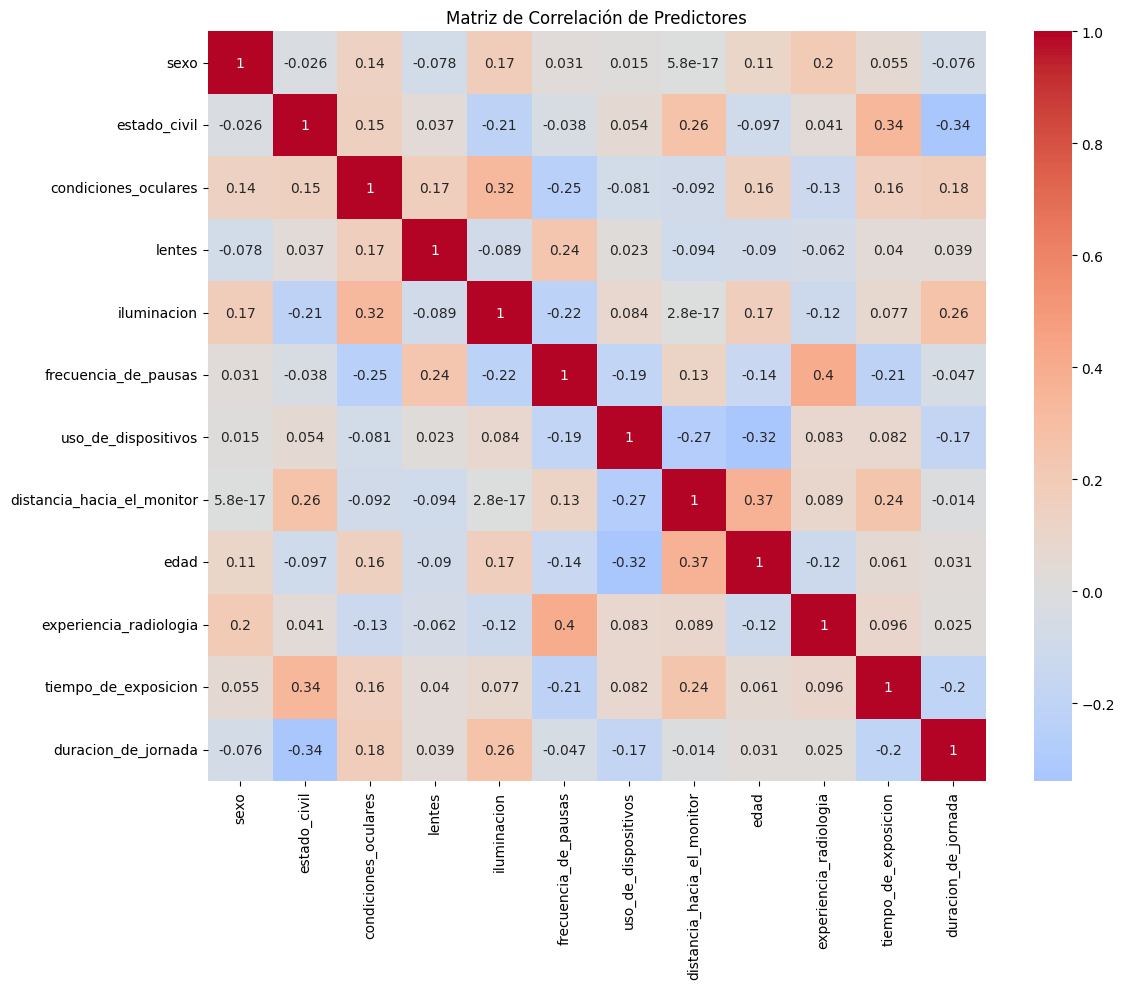


Factores de Inflación de Varianza (VIF):
                      Variable        VIF
8                         edad  28.878503
10        tiempo_de_exposicion  27.515556
11         duracion_de_jornada  13.343524
6          uso_de_dispositivos  10.510124
7   distancia_hacia_el_monitor   6.605158
9       experiencia_radiologia   6.346692
4                  iluminacion   5.651468
5         frecuencia_de_pausas   4.450652
2         condiciones_oculares   3.537313
3                       lentes   3.368409
1                 estado_civil   3.334580
0                         sexo   2.559130

Correlaciones con tiempo_de_exposicion:
tiempo_de_exposicion          1.000000
estado_civil                  0.337753
distancia_hacia_el_monitor    0.243885
condiciones_oculares          0.160573
experiencia_radiologia        0.096067
uso_de_dispositivos           0.082436
iluminacion                   0.077123
edad                          0.060751
sexo                          0.054734
lentes              

In [29]:
# Preparar datos para correlación
# Asegurarnos de incluir tiempo_de_exposicion en el análisis
X = pd.get_dummies(df[cat_vars + num_vars], drop_first=True)

# Matriz de correlación
corr_matrix = X.corr()

# Visualizar matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación de Predictores')
plt.tight_layout()
plt.show()

# Calcular VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nFactores de Inflación de Varianza (VIF):")
print(vif_data.sort_values('VIF', ascending=False))

# Mostrar correlaciones específicas con tiempo_de_exposicion
print("\nCorrelaciones con tiempo_de_exposicion:")
correlaciones = corr_matrix['tiempo_de_exposicion'].sort_values(ascending=False)
print(correlaciones)

## 5. Regresión Logística Simple

Ajustaremos modelos univariados para cada predictor y calcularemos los odds ratios con intervalos de confianza.

In [30]:
# Función para ajustar regresión logística simple
def fit_simple_logistic(X, y, variable):
    model = sm.Logit(y, sm.add_constant(X[variable])).fit(disp=0)
    conf_int = np.exp(model.conf_int())
    odds_ratio = np.exp(model.params)[1]
    return {
        'variable': variable,
        'odds_ratio': odds_ratio,
        'ci_lower': conf_int.iloc[1,0],
        'ci_upper': conf_int.iloc[1,1],
        'p_value': model.pvalues[1]
    }

# Ajustar modelos univariados
univariate_results = []
for var in X.columns:
    try:
        result = fit_simple_logistic(X, df['svi'], var)
        univariate_results.append(result)
    except:
        print(f"No se pudo ajustar el modelo para: {var}")

# Crear tabla de resultados
univariate_df = pd.DataFrame(univariate_results)
univariate_df = univariate_df.sort_values('p_value')
print("\nResultados de Regresión Logística Simple:")
print(univariate_df)


Resultados de Regresión Logística Simple:
                      variable    odds_ratio  ci_lower  ci_upper   p_value
10        tiempo_de_exposicion  1.875389e+00  1.026965  3.424736  0.040701
6          uso_de_dispositivos  2.014186e+00  0.853543  4.753064  0.109941
0                         sexo  2.647059e-01  0.026823  2.612303  0.255165
11         duracion_de_jornada  8.391150e-01  0.604746  1.164314  0.293892
1                 estado_civil  1.955604e+00  0.522619  7.317744  0.319168
9       experiencia_radiologia  1.202739e+00  0.796815  1.815454  0.379537
5         frecuencia_de_pausas  1.646662e+00  0.435267  6.229498  0.462531
8                         edad  9.487651e-01  0.799160  1.126377  0.548030
3                       lentes  1.128205e+00  0.166054  7.665257  0.901797
2         condiciones_oculares  8.888889e-01  0.131583  6.004766  0.903816
4                  iluminacion  4.530244e-11  0.000000       inf  0.999819
7   distancia_hacia_el_monitor  1.000000e+00  0.180722  5

C:\Users\hugo_\AppData\Local\Temp\ipykernel_10096\309532583.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  odds_ratio = np.exp(model.params)[1]
C:\Users\hugo_\AppData\Local\Temp\ipykernel_10096\309532583.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'p_value': model.pvalues[1]
C:\Users\hugo_\AppData\Local\Temp\ipykernel_10096\309532583.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  odds_ratio = np.exp(model.params)[

## 6. Regresión Logística

Desarrollaremos dos modelos de regresión logística:
1. Modelo simple con solo tiempo_de_exposicion
2. Modelo múltiple con tiempo_de_exposicion, iluminacion, frecuencia_de_pausas, y uso_de_dispositivos

In [31]:
# Asegurar que el directorio output existe
import os
os.makedirs('output', exist_ok=True)

# 1. Modelo simple con tiempo_de_exposicion
# Asegurar que tiempo_de_exposicion sea numérico
df['tiempo_de_exposicion'] = pd.to_numeric(df['tiempo_de_exposicion'], errors='coerce')
df['duracion_de_jornada'] = pd.to_numeric(df['duracion_de_jornada'], errors='coerce')


# Crear el primer modelo
X_simple = sm.add_constant(df[['tiempo_de_exposicion']])
model_simple = sm.Logit(df['svi'], X_simple).fit(method='bfgs', disp=0)

print("Modelo 1: Solo tiempo_de_exposicion")
print("===================================")
print(model_simple.summary())

# 2. Modelo múltiple
# Crear dummies manualmente para tener control sobre las categorías de referencia
X_multiple = pd.DataFrame()
X_multiple['tiempo_de_exposicion'] = df['tiempo_de_exposicion']

# Función para procesar variables categóricas
def process_categorical(df, variable):
    # Convertir a string para asegurar consistencia
    df[variable] = df[variable].astype(str)
    # Crear dummies
    dummies = pd.get_dummies(df[variable], prefix=variable, drop_first=True)
    return dummies

# Agregar variables categóricas una por una
selected_vars = ['iluminacion', 'uso_de_dispositivos']

# Procesar cada variable categórica
for var in selected_vars:
    # Crear dummies para cada variable
    var_dummies = process_categorical(df, var)
    if not var_dummies.empty:
        X_multiple = pd.concat([X_multiple, var_dummies], axis=1)
    else:
        print(f"Advertencia: No se pudieron crear variables dummy para {var}")

# Verificar los tipos de datos
print("\nTipos de datos en X_multiple:")
print(X_multiple.dtypes)

# Convertir todo a float64 para evitar problemas
X_multiple = X_multiple.astype(float)

# Agregar constante
X_multiple = sm.add_constant(X_multiple)

# Verificar que no hay valores nulos
print("\nValores nulos en X_multiple:")
print(X_multiple.isnull().sum())

# Ajustar el modelo múltiple usando bfgs
try:
    model_multiple = sm.Logit(df['svi'], X_multiple).fit(method='bfgs', disp=0)
    print("\nModelo 2: Variables múltiples")
    print("===================================")
    print(model_multiple.summary())
except Exception as e:
    print(f"\nError al ajustar el modelo múltiple: {str(e)}")
    print("\nInformación de diagnóstico:")
    print(f"Forma de X_multiple: {X_multiple.shape}")
    print(f"Columnas de X_multiple: {X_multiple.columns.tolist()}")
    raise

# Calcular y organizar los odds ratios e intervalos de confianza
def get_model_results(model, var_names):
    coef = model.params
    conf_int = model.conf_int()
    odds_ratios = np.exp(coef)
    odds_ratios_ci = np.exp(conf_int)
    p_values = model.pvalues
    
    results = pd.DataFrame({
        'Variable': var_names,
        'Odds_Ratio': odds_ratios,
        'CI_Lower': odds_ratios_ci[0],
        'CI_Upper': odds_ratios_ci[1],
        'P_Value': p_values,
        'Coef': coef
    })
    return results.round(4)

# Resultados para ambos modelos
results_simple = get_model_results(model_simple, X_simple.columns)
results_multiple = get_model_results(model_multiple, X_multiple.columns)

# Exportar resultados a Excel
with pd.ExcelWriter('output/logistic_regression_results.xlsx') as writer:
    results_simple.to_excel(writer, sheet_name='Modelo_Simple', index=False)
    results_multiple.to_excel(writer, sheet_name='Modelo_Multiple', index=False)
    
    # También guardar las variables dummy utilizadas y sus tipos de datos
    var_info = pd.DataFrame({
        'Variables': X_multiple.columns,
        'Tipo_de_dato': X_multiple.dtypes.values
    })
    var_info.to_excel(writer, sheet_name='Variables_Modelo_Multiple', index=False)

# Exportar resultados en formato Markdown
markdown_output = """
# Resultados de Regresión Logística

## Modelo 1: Solo tiempo_de_exposicion

| Variable | Coeficiente | Odds Ratio | IC 95% Inferior | IC 95% Superior | Valor p |
|----------|-------------|------------|-----------------|-----------------|----------|
"""

for _, row in results_simple.iterrows():
    markdown_output += f"| {row['Variable']} | {row['Coef']:.3f} | {row['Odds_Ratio']:.3f} | {row['CI_Lower']:.3f} | {row['CI_Upper']:.3f} | {row['P_Value']:.4f} |\n"

markdown_output += """
## Modelo 2: Variables múltiples

| Variable | Coeficiente | Odds Ratio | IC 95% Inferior | IC 95% Superior | Valor p |
|----------|-------------|------------|-----------------|-----------------|----------|
"""

for _, row in results_multiple.iterrows():
    markdown_output += f"| {row['Variable']} | {row['Coef']:.3f} | {row['Odds_Ratio']:.3f} | {row['CI_Lower']:.3f} | {row['CI_Upper']:.3f} | {row['P_Value']:.4f} |\n"

# Agregar interpretación de las categorías de referencia
markdown_output += """
## Categorías de Referencia

Las siguientes categorías se utilizaron como referencia en el modelo múltiple:
- Iluminación: Primera categoría
- Frecuencia de pausas: Primera categoría
- Uso de dispositivos: Primera categoría

Los coeficientes y odds ratios para las variables dummy se interpretan en relación a estas categorías de referencia.
"""

# Guardar resultados en Markdown
with open('output/logistic_regression_results.md', 'w', encoding='utf-8') as f:
    f.write(markdown_output)

# Imprimir información sobre el ajuste del modelo
print("\nInformación del ajuste del modelo múltiple:")
print(f"Pseudo R-cuadrado: {model_multiple.prsquared:.4f}")
print(f"AIC: {model_multiple.aic:.2f}")
print(f"BIC: {model_multiple.bic:.2f}")
print(f"Log-Likelihood: {model_multiple.llf:.2f}")

# Imprimir información de diagnóstico adicional
print("\nInformación de las variables en el modelo múltiple:")
print("\nEstadísticas descriptivas de X_multiple:")
print(X_multiple.describe())

Modelo 1: Solo tiempo_de_exposicion
                           Logit Regression Results                           
Dep. Variable:                    svi   No. Observations:                   40
Model:                          Logit   Df Residuals:                       38
Method:                           MLE   Df Model:                            1
Date:                Tue, 14 Oct 2025   Pseudo R-squ.:                  0.2061
Time:                        23:03:07   Log-Likelihood:                -11.965
converged:                       True   LL-Null:                       -15.071
Covariance Type:            nonrobust   LLR p-value:                   0.01269
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.8281      3.096     -1.560      0.119     -10.896       1.240
tiempo_de_exposicion     0.6288      0.307      2.047      0.041 

d:\encuesta_fatiga_visual\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Información del ajuste del modelo múltiple:
Pseudo R-cuadrado: 0.4852
AIC: 27.52
BIC: 37.65
Log-Likelihood: -7.76

Información de las variables en el modelo múltiple:

Estadísticas descriptivas de X_multiple:
       const  tiempo_de_exposicion  iluminacion_1  uso_de_dispositivos_1  \
count   40.0             40.000000      40.000000              40.000000   
mean     1.0             11.925000       0.750000               0.100000   
std      0.0              2.463971       0.438529               0.303822   
min      1.0              8.000000       0.000000               0.000000   
25%      1.0             10.000000       0.750000               0.000000   
50%      1.0             12.000000       1.000000               0.000000   
75%      1.0             13.000000       1.000000               0.000000   
max      1.0             16.000000       1.000000               1.000000   

       uso_de_dispositivos_2  uso_de_dispositivos_3  
count              40.000000              40.000000

## 7. Diagnóstico del Modelo

Verificaremos los supuestos del modelo y analizaremos puntos influyentes.

In [32]:
# Diagnóstico para ambos modelos
def plot_residuals(model, title):
    residuals = model.resid_pearson
    predicted_probs = model.predict()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(predicted_probs, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Probabilidades predichas')
    plt.ylabel('Residuos de Pearson')
    plt.title(f'Residuos vs Probabilidades Predichas - {title}')
    plt.grid(True)
    return residuals, predicted_probs

# Análisis de residuos para el modelo simple
residuals_simple, pred_simple = plot_residuals(model_simple, "Modelo Simple")
plt.savefig('output/residuals_simple.png')
plt.close()

# Análisis de residuos para el modelo múltiple
residuals_multiple, pred_multiple = plot_residuals(model_multiple, "Modelo Múltiple")
plt.savefig('output/residuals_multiple.png')
plt.close()

# Identificar observaciones con residuos extremos para ambos modelos
def analyze_residuals(residuals, predicted_probs, title):
    residual_threshold = 2
    extreme_residuals = pd.DataFrame({
        'Residuos': residuals,
        'Prob_predicha': predicted_probs
    })
    print(f"\nObservaciones con residuos extremos (|residuo| > 2) - {title}:")
    print(extreme_residuals[abs(extreme_residuals['Residuos']) > residual_threshold])
    print(f"\nEstadísticas de los residuos - {title}:")
    print(pd.Series(residuals).describe())

# Analizar residuos para ambos modelos
analyze_residuals(residuals_simple, pred_simple, "Modelo Simple")
analyze_residuals(residuals_multiple, pred_multiple, "Modelo Múltiple")


Observaciones con residuos extremos (|residuo| > 2) - Modelo Simple:
    Residuos  Prob_predicha
0  -2.841854       0.889821
3  -2.075180       0.811547
21 -2.075180       0.811547

Estadísticas de los residuos - Modelo Simple:
count    40.000000
mean      0.032239
std       0.809036
min      -2.841854
25%       0.073058
50%       0.187632
75%       0.351883
max       0.903724
dtype: float64

Observaciones con residuos extremos (|residuo| > 2) - Modelo Múltiple:
   Residuos  Prob_predicha
0 -3.607712       0.928651

Estadísticas de los residuos - Modelo Múltiple:
count    40.000000
mean      0.003282
std       0.719381
min      -3.607712
25%       0.002592
50%       0.085463
75%       0.169608
max       1.209860
dtype: float64


## 8. Interpretación de Factores de Riesgo

Identificaremos y visualizaremos los factores de riesgo significativos del modelo final.

In [33]:
# Función para calcular y visualizar efectos marginales
def plot_marginal_effects(model, var_name, X_data, title):
    plt.figure(figsize=(10, 6))
    
    # Crear rango de valores para la variable
    if var_name in X_data.select_dtypes(include=[np.number]).columns:
        x_range = np.linspace(X_data[var_name].min(), X_data[var_name].max(), 100)
        X_pred = X_data.copy()
        
        predicted_probs = []
        ci_lower = []
        ci_upper = []
        
        for x in x_range:
            X_pred[var_name] = x
            pred = model.predict(X_pred)
            predicted_probs.append(pred.mean())
            # Calcular intervalos de confianza
            se = np.sqrt(pred.mean() * (1 - pred.mean()) / len(pred))
            ci_lower.append(pred.mean() - 1.96 * se)
            ci_upper.append(pred.mean() + 1.96 * se)
        
        plt.plot(x_range, predicted_probs, 'b-', label=f'Efecto marginal de {var_name}')
        plt.fill_between(x_range, ci_lower, ci_upper, alpha=0.2, color='b')
        
    else:  # Para variables dummy
        # Obtener las columnas que corresponden a la variable categórica
        var_cols = [col for col in X_data.columns if var_name in col]
        if not var_cols:
            print(f"No se encontraron columnas dummy para {var_name}")
            return
            
        categories = ['Referencia'] + [col.split('_')[-1] for col in var_cols]
        X_pred = X_data.copy()
        
        # Calcular probabilidad para categoría de referencia
        for col in var_cols:
            X_pred[col] = 0
        pred_ref = model.predict(X_pred).mean()
        predicted_probs = [pred_ref]
        
        # Calcular probabilidades para cada categoría
        for col in var_cols:
            X_pred = X_data.copy()
            for other_col in var_cols:
                X_pred[other_col] = 0
            X_pred[col] = 1
            pred = model.predict(X_pred)
            predicted_probs.append(pred.mean())
        
        plt.bar(range(len(categories)), predicted_probs)
        plt.xticks(range(len(categories)), categories, rotation=45)
    
    plt.xlabel(var_name)
    plt.ylabel('Probabilidad predicha de SVI')
    plt.title(f'Efecto Marginal de {var_name} en la probabilidad de SVI\n{title}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt

# Generar efectos marginales para el modelo simple
plot_marginal_effects(model_simple, 'tiempo_de_exposicion', X_simple, "Modelo Simple")
plt.savefig('output/marginal_effect_tiempo_simple.png')
plt.close()

# Generar efectos marginales para el modelo múltiple
# Para tiempo_de_exposicion
plot_marginal_effects(model_multiple, 'tiempo_de_exposicion', X_multiple, "Modelo Múltiple")
plt.savefig('output/marginal_effect_tiempo_multiple.png')
plt.close()

# Para variables categóricas
for var in ['iluminacion', 'uso_de_dispositivos']:
    plot_marginal_effects(model_multiple, var, X_multiple, "Modelo Múltiple")
    plt.savefig(f'output/marginal_effect_{var}_multiple.png')
    plt.close()

print("Se han guardado los gráficos de efectos marginales en:")
print("1. output/marginal_effect_tiempo_simple.png")
print("2. output/marginal_effect_tiempo_multiple.png")
print("3. output/marginal_effect_iluminacion_multiple.png")
print("4. output/marginal_effect_uso_de_dispositivos_multiple.png")

Se han guardado los gráficos de efectos marginales en:
1. output/marginal_effect_tiempo_simple.png
2. output/marginal_effect_tiempo_multiple.png
3. output/marginal_effect_iluminacion_multiple.png
4. output/marginal_effect_uso_de_dispositivos_multiple.png


## 9. Visualización de Resultados

Generaremos la curva ROC y visualizaciones adicionales para comunicar los resultados del modelo.

In [34]:
# Función para evaluar el rendimiento del modelo
def evaluate_model(y_true, model, title):
    predicted_probs = model.predict()
    y_pred = (predicted_probs >= 0.5).astype(int)
    
    # Calcular curva ROC
    fpr, tpr, _ = roc_curve(y_true, predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    # Crear gráfico ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'Curva ROC - {title}')
    plt.legend(loc="lower right")
    plt.savefig(f'output/roc_curve_{title.lower().replace(" ", "_")}.png')
    plt.close()
    
    # Calcular métricas de rendimiento
    print(f"\nMétricas de rendimiento - {title}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"Recall: {recall_score(y_true, y_pred):.3f}")
    print(f"F1-score: {f1_score(y_true, y_pred):.3f}")
    
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nMatriz de confusión - {title}:")
    print("                 Predicho NO SVI  Predicho SVI")
    print(f"Real NO SVI           {cm[0,0]:12d}  {cm[0,1]:12d}")
    print(f"Real SVI              {cm[1,0]:12d}  {cm[1,1]:12d}")
    
    return {
        'auc': roc_auc,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }

# Evaluar modelo simple
metrics_simple = evaluate_model(df['svi'], model_simple, "Modelo Simple")

# Evaluar modelo múltiple
metrics_multiple = evaluate_model(df['svi'], model_multiple, "Modelo Múltiple")

# Crear DataFrame con métricas completas
comparison_df = pd.DataFrame({
    'Métrica': ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Modelo Simple': [metrics_simple['auc'], metrics_simple['accuracy'], 
                     metrics_simple['precision'], metrics_simple['recall'], 
                     metrics_simple['f1']],
    'Modelo Múltiple': [metrics_multiple['auc'], metrics_multiple['accuracy'], 
                       metrics_multiple['precision'], metrics_multiple['recall'], 
                       metrics_multiple['f1']]
})

# Guardar comparación en Excel
comparison_df.to_excel('output/model_comparison.xlsx', index=False)

# Mostrar resultados formateados
print("\nComparación de modelos:")
print(comparison_df.round(3).to_string(index=False))
print("\nSe han guardado los resultados de la comparación en 'output/model_comparison.xlsx'")


Métricas de rendimiento - Modelo Simple:
Accuracy: 0.875
Precision: 0.875
Recall: 1.000
F1-score: 0.933

Matriz de confusión - Modelo Simple:
                 Predicho NO SVI  Predicho SVI
Real NO SVI                      0             5
Real SVI                         0            35

Métricas de rendimiento - Modelo Múltiple:
Accuracy: 0.925
Precision: 0.944
Recall: 0.971
F1-score: 0.958

Matriz de confusión - Modelo Múltiple:
                 Predicho NO SVI  Predicho SVI
Real NO SVI                      3             2
Real SVI                         1            34

Comparación de modelos:
  Métrica  Modelo Simple  Modelo Múltiple
      AUC          0.834            0.940
 Accuracy          0.875            0.925
Precision          0.875            0.944
   Recall          1.000            0.971
 F1-Score          0.933            0.958

Se han guardado los resultados de la comparación en 'output/model_comparison.xlsx'

Métricas de rendimiento - Modelo Múltiple:
Accuracy: 0.925